https://community.ibm.com/community/user/blogs/steven-macko/2019/07/11/telco-customer-churn-1113

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay
)
from sklearn.model_selection import (
    cross_validate,
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from xgboost import XGBClassifier

In [2]:
# df_demographics = pd.read_excel('Telecommunications_Industry/Telco_customer_churn_demographics.xlsx')
# df_location = pd.read_excel('Telecommunications_Industry/Telco_customer_churn_location.xlsx')
# df_population = pd.read_excel('Telecommunications_Industry/Telco_customer_churn_population.xlsx')
# df_services = pd.read_excel('Telecommunications_Industry/Telco_customer_churn_services.xlsx')
df_status = pd.read_excel('Telecommunications_Industry/Telco_customer_churn_status.xlsx')
df = pd.read_excel('Telecommunications_Industry/Telco_customer_churn.xlsx')

In [3]:
# df_demographics.head()
# df_location.head()
# df_population.head()
# df_services.head()
# df_status.head()
# df.head()

In [4]:
# # Services

# df_services.columns = df_services.columns.str.replace(' ', '')

# df_services.eval(
#     'TenureinMonths * AvgMonthlyLongDistanceCharges - TotalLongDistanceCharges'
# ).abs().lt(1e-6).all()  # is True

# df_services.eval(
#     'TotalRevenue - (TotalCharges - TotalRefunds + TotalExtraDataCharges + TotalLongDistanceCharges)'
# ).abs().lt(1e-6).all()  # is True

In [5]:
df_status.columns = df_status.columns.str.replace(' ', '')

In [6]:
df.columns = df.columns.str.replace(' ', '')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# df = df.dropna()

# set(df.loc[df['MultipleLines'] == 'No phone service', 'CustomerID']) == set(df.loc[df['PhoneService'] == 'No', 'CustomerID'])
df['MultipleLines'] = df['MultipleLines'].replace({'No phone service': 'No'})

no_internet_service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# for col in no_internet_service_cols:
#     ans = set(df.loc[df[col] == 'No internet service', 'CustomerID']) == set(df.loc[df['InternetService'] == 'No', 'CustomerID'])
#     print(f'{col}: {ans}')

df[no_internet_service_cols] = df[no_internet_service_cols].replace({'No internet service': 'No'})

In [7]:
df = pd.merge(df, df_status[['CustomerID', 'ChurnCategory']], on='CustomerID')

In [8]:
mapping = df.groupby('ChurnReason')['ChurnCategory'].agg(lambda x: x.mode()[0]).to_dict()
mapping['Lack of self-service on Website'] = 'Dissatisfaction'

df['ChurnCategoryFromReason'] = df['ChurnReason'].map(mapping)

In [9]:
# sns.histplot(df, x='TenureMonths', hue='ChurnLabel', element='step')

In [10]:
# sns.histplot(df, x='MonthlyCharges', hue='ChurnLabel', element='step')

In [11]:
# sns.histplot(df, x='TotalCharges', hue='ChurnLabel', element='step')

<Axes: xlabel='CLTV', ylabel='Count'>

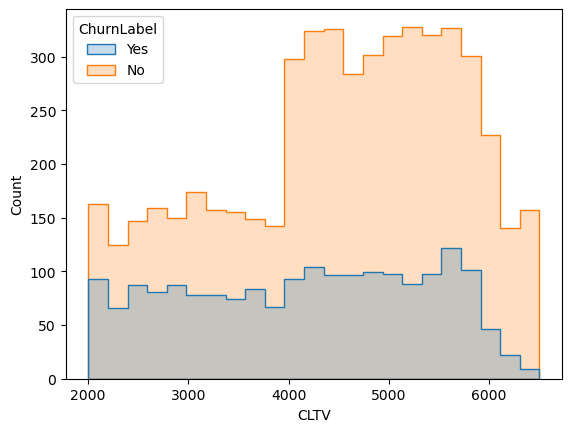

In [12]:
sns.histplot(df, x='CLTV', hue='ChurnLabel', element='step')

In [13]:
# (df.TenureMonths * df.MonthlyCharges / df.TotalCharges - 1).plot.hist()

In [14]:
# df.groupby(['Gender', 'ChurnLabel']).size().unstack().plot(kind='bar')

In [15]:
# df.groupby(['SeniorCitizen', 'ChurnLabel']).size().unstack().plot(kind='bar')

In [16]:
# df.groupby(['Partner', 'ChurnLabel']).size().unstack().plot(kind='bar')

In [17]:
# df.groupby(['Dependents', 'ChurnLabel']).size().unstack().plot(kind='bar')

In [18]:
# df.groupby(['PhoneService', 'ChurnLabel']).size().unstack().plot(kind='bar')

In [19]:
# df.groupby(['MultipleLines', 'ChurnLabel']).size().unstack().plot(kind='bar')

In [20]:
# df.groupby(['InternetService', 'ChurnLabel']).size().unstack().plot(kind='bar')

In [21]:
# df.groupby(['OnlineSecurity', 'ChurnLabel']).size().unstack().plot(kind='bar')

In [22]:
# df.groupby(['OnlineBackup', 'ChurnLabel']).size().unstack().plot(kind='bar')

In [23]:
# df.groupby(['DeviceProtection', 'ChurnLabel']).size().unstack().plot(kind='bar')

In [24]:
# df.groupby(['TechSupport', 'ChurnLabel']).size().unstack().plot(kind='bar')

In [25]:
# df.groupby(['Contract', 'ChurnLabel']).size().unstack().plot(kind='bar')

In [26]:
# df.groupby(['PaperlessBilling', 'ChurnLabel']).size().unstack().plot(kind='bar')

In [27]:
# df.groupby(['PaymentMethod', 'ChurnLabel']).size().unstack().plot(kind='bar')

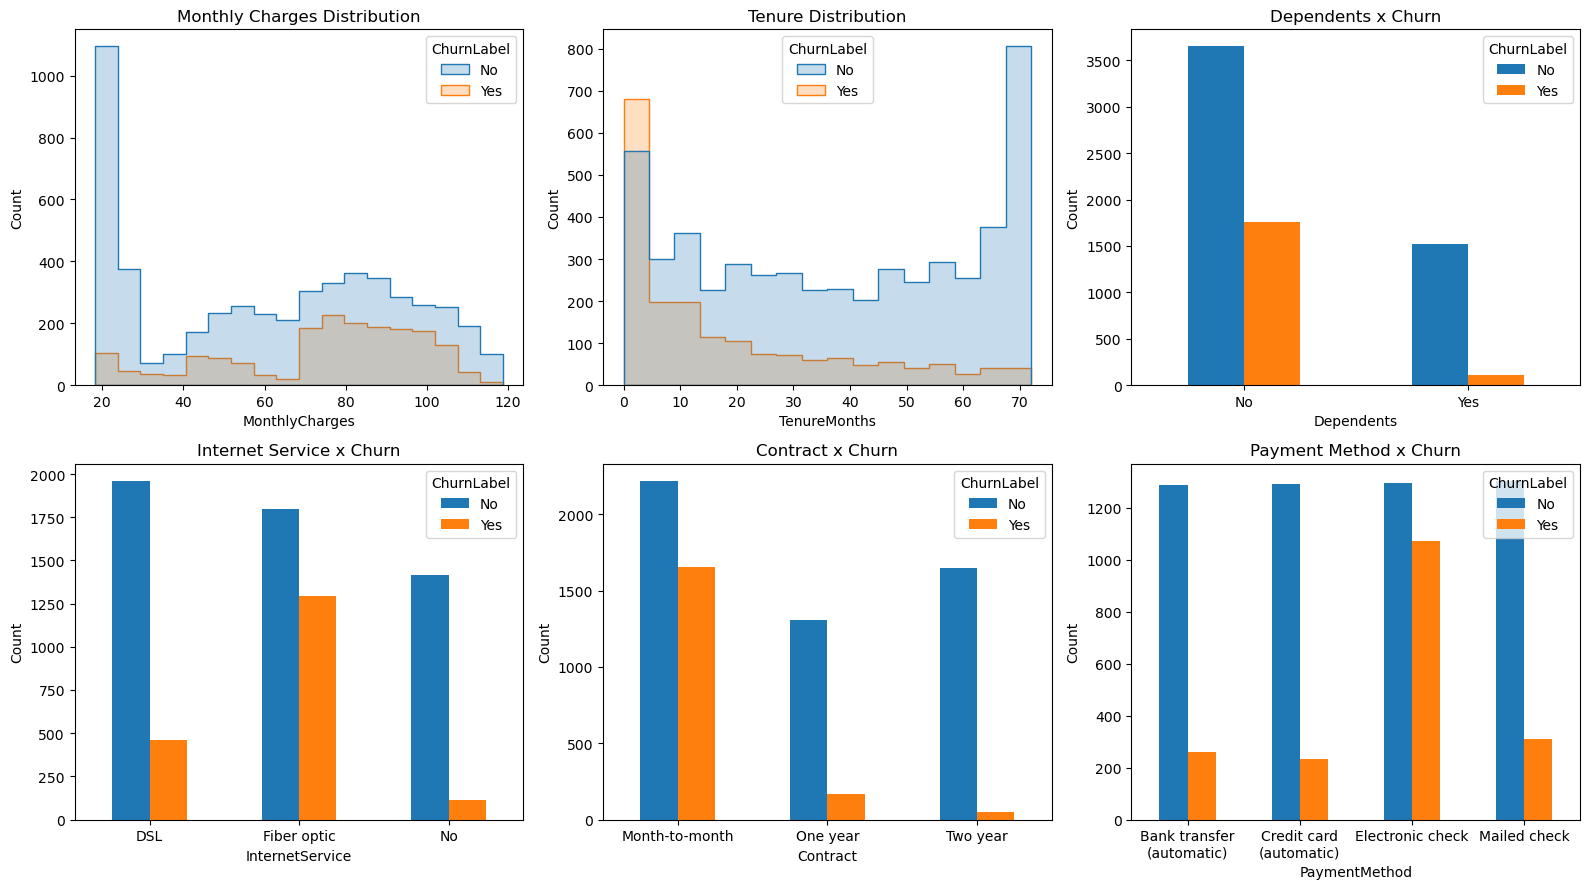

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(16, 9))

sns.histplot(df, x='MonthlyCharges', hue='ChurnLabel', hue_order=('No', 'Yes'), element='step', ax=ax[0, 0])
ax[0, 0].set_title('Monthly Charges Distribution')

sns.histplot(df, x='TenureMonths', hue='ChurnLabel', hue_order=('No', 'Yes'), element='step', ax=ax[0, 1])
ax[0, 1].set_title('Tenure Distribution')

df.groupby(['Dependents', 'ChurnLabel']).size().unstack().plot(kind='bar', ax=ax[0, 2], title='Dependents x Churn')
ax[0, 2].tick_params(axis='x', rotation=0)
ax[0, 2].set_ylabel('Count')

df.groupby(['InternetService', 'ChurnLabel']).size().unstack().plot(kind='bar', ax=ax[1, 0], title='Internet Service x Churn')
ax[1, 0].tick_params(axis='x', rotation=0)
ax[1, 0].set_ylabel('Count')

df.groupby(['Contract', 'ChurnLabel']).size().unstack().plot(kind='bar', ax=ax[1, 1], title='Contract x Churn')
ax[1, 1].tick_params(axis='x', rotation=0)
ax[1, 1].set_ylabel('Count')

(
    df.groupby(['PaymentMethod', 'ChurnLabel'])
        .size()
        .unstack()
        .rename(index={
            "Bank transfer (automatic)": "Bank transfer\n(automatic)",
            "Credit card (automatic)": "Credit card\n(automatic)"
        })
        .plot(kind='bar', ax=ax[1, 2], title='Payment Method x Churn')
)
ax[1, 2].tick_params(axis='x', rotation=0)
ax[1, 2].set_ylabel('Count')

# ax[1, 2].axis('off')

plt.tight_layout()
fig.savefig('Features.png')
plt.show()

## Data Transformations

Ignore `Count`, `ZipCode`, `Latitude`, `Longitude`, `TotalCharges`, `ChurnValue`, `ChurnScore`, `CLTV`

In [29]:
# numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_features = ['TenureMonths', 'MonthlyCharges']

Ignore `CustomerID`, `Country`, `State`, `City`, `LatLong`, `ChurnLabel`, `ChurnReason`

In [30]:
# categorical_features = df.select_dtypes(include=['object']).columns.tolist()

categorical_features = [
    'Gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

In [31]:
X = df[numeric_features + categorical_features]

In [32]:
y = df.ChurnLabel.map({'Yes': 1, 'No': 0})

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

## Model evaluation utils

In [35]:
def plot_confusion_matrix(classifier, X, y, labels=('No', 'Yes')):
    y_pred = classifier.predict(X)
    cm = confusion_matrix(y, y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot(ax=ax)
    ax.set_title('Confusion matrix')
    fig.tight_layout()
    plt.show()

    return disp

In [36]:
def plot_precision_recall(classifier, X, y):
    display = PrecisionRecallDisplay.from_estimator(lr, X_test, y_test)
    _ = display.ax_.set_title('2-class Precision-Recall curve')
    # display.figure_.savefig('LogisticRegression_Precision-Recall_curve.png', dpi=300, bbox_inches='tight')
    return display

In [37]:
def plot_roc_curve_(classifier, X, y):
    display = RocCurveDisplay.from_estimator(classifier, X, y)
    _ = display.ax_.set_title('2-class ROC curve')
        # display.figure_.savefig('LogisticRegression_ROC_curve.png', dpi=300, bbox_inches='tight')
    return display

## Hyperparameter tuning

In [38]:
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [39]:
# # linear regression

# lr = Pipeline(
#     steps=[
#         ('preprocess', preprocess),
#         ('logistic_regression', LogisticRegression(max_iter=1000))
#     ]
# )

# param_grid = {
#     'logistic_regression__C': [1, 5, 10],
#     'logistic_regression__class_weight': [None, 'balanced']
# }

# clf = GridSearchCV(lr, param_grid, scoring='f1', cv=cv)
# clf.fit(X, y)
# results = clf.cv_results_

# for i in range(len(results['params'])):
#     param = results['params'][i]
#     mean = results['mean_test_score'][i]
#     std = results['std_test_score'][i]
#     print(param, mean)

In [40]:
# # random forest

# rf = Pipeline(
#     steps=[
#         ('preprocess', preprocess),
#         ('random_forest_classifier', RandomForestClassifier(random_state=42))
#     ]
# )

# param_grid = {
#     'random_forest_classifier__max_depth': [1, 4, 7, 10, 13, 16],
#     'random_forest_classifier__class_weight': [None, 'balanced']
# }

# clf = GridSearchCV(rf, param_grid, scoring='f1', cv=cv)
# clf.fit(X, y)
# results = clf.cv_results_

# for i in range(len(results['params'])):
#     param = results['params'][i]
#     mean = results['mean_test_score'][i]
#     std = results['std_test_score'][i]
#     print(param, mean)

In [41]:
# # xgboost

# xgb = lr = Pipeline(
#     steps=[
#         ('preprocess', preprocess),
#         ('xgboost_classifier', XGBClassifier(tree_method='hist'))
#     ]
# )

# param_grid = {
#     'xgboost_classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
#     'xgboost_classifier__max_depth': [1, 2, 3, 4, 5, 6]}

# clf = GridSearchCV(xgb, param_grid, scoring='f1', cv=cv)
# clf.fit(X, y)
# results = clf.cv_results_
# print(clf.best_params_, clf.best_score_)

In [42]:
# print(clf.best_params_, clf.best_score_)

## Model comparison

In [43]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [44]:
lr = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('logistic_regression', LogisticRegression(max_iter=1000, class_weight=None))
    ]
)

In [45]:
lr_balanced = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('logistic_regression', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]
)

In [46]:
rf = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('random_forest_classifier', RandomForestClassifier(max_depth=10, random_state=42, class_weight=None))
    ]
)

In [47]:
rf_balanced = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('random_forest_classifier', RandomForestClassifier(max_depth=10, random_state=42, class_weight='balanced'))
    ]
)

In [48]:
xgb = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('xgboost_classifier', XGBClassifier(tree_method='hist', learning_rate=0.1, max_depth=3))
    ]
)

In [49]:
def get_scores(pipe, X, y, cv):
    cv_results = cross_validate(
        pipe, X, y, cv=cv,
        scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'average_precision']
    )
    scores = {
        'accuracy': cv_results['test_accuracy'].mean(),
        'precision': cv_results['test_precision'].mean(),
        'recall': cv_results['test_recall'].mean(),
        'f1': cv_results['test_f1'].mean(),
        'roc_auc': cv_results['test_roc_auc'].mean(),
        'average_precision': cv_results['test_average_precision'].mean()
    }
    return scores

In [50]:
args = (X, y, cv)
lr_scores = get_scores(lr, *args)
lr_balanced_scores = get_scores(lr_balanced, *args)
rf_scores = get_scores(rf, *args)
rf_balanced_scores = get_scores(rf_balanced, *args)
xgb_scores = get_scores(xgb, *args)

In [51]:
scores = pd.DataFrame({
    'LogisticRegression': lr_scores,
    'LogisticRegression_balanced': lr_balanced_scores,
    'RandomForestClassifier': rf_scores,
    'RandomForestClassifier_balanced': rf_balanced_scores,
    'XGBClassifier': xgb_scores
})

XGBClassifier has the best accuracy, precision, roc_auc, and average_precision.

LogisticRegression_balanced has the best recall.

RandomForestClassifier_balanced has the best f1.

In [52]:
scores

,LogisticRegression,LogisticRegression_balanced,RandomForestClassifier,RandomForestClassifier_balanced,XGBClassifier
accuracy,0.808605,0.760047,0.806049,0.783188,0.812864
precision,0.662916,0.531810,0.670991,0.569965,0.679672
recall,0.567702,0.799366,0.528113,0.746931,0.557523
f1,0.611313,0.638669,0.590859,0.646528,0.612509
roc_auc,0.856081,0.856044,0.856719,0.857011,0.862889
average_precision,0.672577,0.671690,0.675430,0.673679,0.689238


In [53]:
best_model = rf_balanced

In [54]:
rf_balanced.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('random_forest_classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [55]:
y_pred = rf_balanced.predict(X_test)

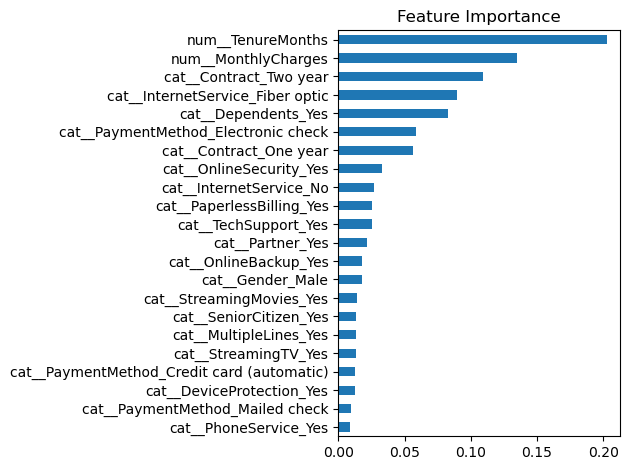

In [56]:
importances = pd.Series(
    rf_balanced.named_steps['random_forest_classifier'].feature_importances_,
    index=rf.named_steps['preprocess'].get_feature_names_out()
)
fig, ax = plt.subplots()
importances.sort_values(ascending=True).plot.barh()
ax.set_title('Feature Importance')
plt.tight_layout()
fig.savefig('FeatureImportance.png')
plt.show()

## Model evaluation

In [57]:
cols = [
    'Dependents', 'InternetService', 'Contract', 'PaymentMethod',
    'TenureMonths', 'MonthlyCharges', 'CLTV'
]

df_test = df.loc[y_test.index, cols]

df_test['bin_TenureMonths'] = pd.qcut(df_test['TenureMonths'], 4, labels=('low', 'mid-low', 'mid-high', 'high'))
df_test['bin_MonthlyCharges'] = pd.qcut(df_test['MonthlyCharges'], 4, labels=('low', 'mid-low', 'mid-high', 'high'))
df_test['bin_CLTV'] = pd.qcut(df_test['CLTV'], 4, labels=('low', 'mid-low', 'mid-high', 'high'))

y_true = y_test
df_test.loc[:, 'y_true'] = y_true
# y_pred = best_model.predict(X_test)
df_test.loc[:, 'y_pred'] = y_pred
y_prob = best_model.predict_proba(X_test)[:, 1]
df_test.loc[:, 'y_prob'] = y_prob

In [58]:
def score_by_category(df, category):

    rows = []

    for name, group in df.groupby(category, observed=False):
        
        y_true = group.y_true
        y_pred = group.y_pred
        y_prob = group.y_prob

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        # specificity = tn / (tn + fp)

        roc_auc = roc_auc_score(y_true, y_prob)
        average_precision = average_precision_score(y_true, y_prob)

        rows.append(
            {
                category: name,
                'samples': len(group),
                'tn': tn,
                'fp': fp,
                'fn': fn,
                'tp': tp,
                'positives': tp + fn,
                'negatives': fp + tn,
                'p/n': (tp + fn) / (fp + tn),
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                # 'specificity': specificity,
                'roc_auc': roc_auc,
                'average_precision': average_precision
        })

    return pd.DataFrame(rows).set_index(category)

**Precision:** Of those who are predicted to churn, how many actually did churn?

`precision = tp / (tp + fp) = tp / pred_p`

**Recall:** Of those who actually churned, how many are correctly predicted to churn?

`recall = tp / (tp + fn) = tp / actual_p`


In [59]:
# score_by_category(df_test, 'Dependents')

Recall is low for Dependents == 'Yes'

In [60]:
# score_by_category(df_test, 'InternetService')

Precision and recall are low for InternetService == 'No'

<!-- <span style="color:red">Merge DSL and No?</span> -->

In [61]:
# score_by_category(df_test, 'Contract')

Precision and recall are low for Contract == 'One year' and → 0 for Contract == 'Two year'

<!-- <span style="color:red">Merge One year and Two year?</span> -->

In [62]:
# score_by_category(df_test, 'PaymentMethod')

<!-- <span style="color:red">Merge Bank transfer (automatic), Credit card (automatic), and Mailed check?</span> -->

In [63]:
# score_by_category(df_test, 'bin_TenureMonths')

f1 is low for bin_TenureMonths > 55.0

In [64]:
# score_by_category(df_test, 'bin_MonthlyCharges')

In [65]:
score_by_category(df_test, 'bin_CLTV')

,samples,tn,fp,fn,tp,positives,negatives,p/n,accuracy,precision,recall,f1,roc_auc,average_precision
bin_CLTV,,,,,,,,,,,,,,
low,353,157,69,31,96,127,226,0.561947,0.716714,0.581818,0.755906,0.657534,0.812713,0.709294
mid-low,352,208,53,21,70,91,261,0.348659,0.789773,0.569106,0.769231,0.654206,0.876258,0.704258
mid-high,352,221,49,25,57,82,270,0.303704,0.789773,0.537736,0.695122,0.606383,0.857543,0.601493
high,352,236,42,27,47,74,278,0.266187,0.803977,0.528090,0.635135,0.576687,0.843914,0.595164


In [66]:
score_by_bin_CLTV = score_by_category(df_test, 'bin_CLTV')

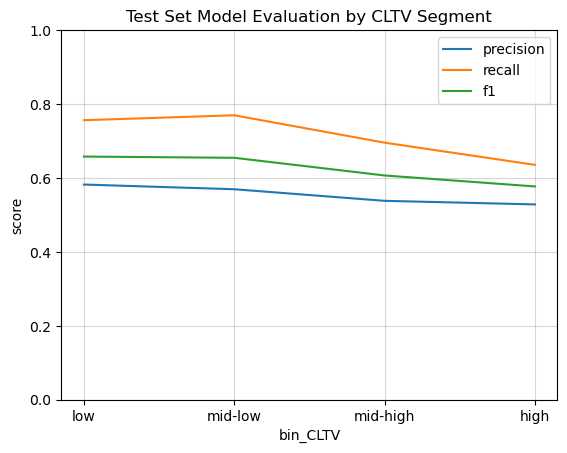

In [67]:
fig, ax = plt.subplots()
sns.lineplot(data=score_by_bin_CLTV, x='bin_CLTV', y='precision', label='precision')
sns.lineplot(data=score_by_bin_CLTV, x='bin_CLTV', y='recall', label='recall')
sns.lineplot(data=score_by_bin_CLTV, x='bin_CLTV', y='f1', label='f1')
# sns.lineplot(data=score_by_bin_CLTV, x='bin_CLTV', y='roc_auc', label='roc_auc')
ax.set_title('Test Set Model Evaluation by CLTV Segment')
ax.set_ylim(0, 1)
ax.set_ylabel('score')
ax.grid(alpha=0.5)
fig.savefig('Test_Set_Model_Evaluation_by_CLTV_Segment.png')
# plt.show()